# Aviation Data Analysis Notebook

In [192]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
%matplotlib inline

In [194]:
#read in data
df_og = pd.read_csv("data/Aviation_Data.csv")

/var/folders/zp/y3_8cd0s1tz68ksgv9pnl2ch0000gn/T/ipykernel_52920/513185973.py:2: DtypeWarning: Columns (6,7,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df_og = pd.read_csv("data/Aviation_Data.csv")


In [196]:
df_og.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90348 entries, 0 to 90347
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                88889 non-null  object 
 1   Investigation.Type      90348 non-null  object 
 2   Accident.Number         88889 non-null  object 
 3   Event.Date              88889 non-null  object 
 4   Location                88837 non-null  object 
 5   Country                 88663 non-null  object 
 6   Latitude                34382 non-null  object 
 7   Longitude               34373 non-null  object 
 8   Airport.Code            50132 non-null  object 
 9   Airport.Name            52704 non-null  object 
 10  Injury.Severity         87889 non-null  object 
 11  Aircraft.damage         85695 non-null  object 
 12  Aircraft.Category       32287 non-null  object 
 13  Registration.Number     87507 non-null  object 
 14  Make                    88826 non-null

In [198]:
df_og.head()

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaN
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.922223,-81.878056,NaN,NaN,...,Personal,NaN,3.0,NaN,NaN,NaN,IMC,Cruise,Probable Cause,26-02-2007
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,12-09-2000
4,20041105X01764,Accident,CHI79FA064,1979-08-02,"Canton, OH",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,1.0,2.0,NaN,0.0,VMC,Approach,Probable Cause,16-04-1980


In [252]:
df = df_og.copy()

In [3]:
#Jackson Work Space

# Mike Work Space

## Preliminary Formatting Change

In [256]:
#replace "." with "_" in column names for ease of copy, paste

df.columns = df.columns.str.replace('.', "_")

In [258]:
print(df.info(), '\n \n')
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90348 entries, 0 to 90347
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event_Id                88889 non-null  object 
 1   Investigation_Type      90348 non-null  object 
 2   Accident_Number         88889 non-null  object 
 3   Event_Date              88889 non-null  object 
 4   Location                88837 non-null  object 
 5   Country                 88663 non-null  object 
 6   Latitude                34382 non-null  object 
 7   Longitude               34373 non-null  object 
 8   Airport_Code            50132 non-null  object 
 9   Airport_Name            52704 non-null  object 
 10  Injury_Severity         87889 non-null  object 
 11  Aircraft_damage         85695 non-null  object 
 12  Aircraft_Category       32287 non-null  object 
 13  Registration_Number     87507 non-null  object 
 14  Make                    88826 non-null

,Event_Id,Investigation_Type,Accident_Number,Event_Date,Location,Country,Latitude,Longitude,Airport_Code,Airport_Name,...,Purpose_of_flight,Air_carrier,Total_Fatal_Injuries,Total_Serious_Injuries,Total_Minor_Injuries,Total_Uninjured,Weather_Condition,Broad_phase_of_flight,Report_Status,Publication_Date
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaN
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.922223,-81.878056,NaN,NaN,...,Personal,NaN,3.0,NaN,NaN,NaN,IMC,Cruise,Probable Cause,26-02-2007
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,12-09-2000
4,20041105X01764,Accident,CHI79FA064,1979-08-02,"Canton, OH",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,1.0,2.0,NaN,0.0,VMC,Approach,Probable Cause,16-04-1980


In [260]:
# Extracting year from Event Date to assess how data changes by year

df['Year'] = [str(year).split('-')[0] for year in df['Event_Date']]

In [262]:
print(df.info(), '\n \n')
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90348 entries, 0 to 90347
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event_Id                88889 non-null  object 
 1   Investigation_Type      90348 non-null  object 
 2   Accident_Number         88889 non-null  object 
 3   Event_Date              88889 non-null  object 
 4   Location                88837 non-null  object 
 5   Country                 88663 non-null  object 
 6   Latitude                34382 non-null  object 
 7   Longitude               34373 non-null  object 
 8   Airport_Code            50132 non-null  object 
 9   Airport_Name            52704 non-null  object 
 10  Injury_Severity         87889 non-null  object 
 11  Aircraft_damage         85695 non-null  object 
 12  Aircraft_Category       32287 non-null  object 
 13  Registration_Number     87507 non-null  object 
 14  Make                    88826 non-null

,Event_Id,Investigation_Type,Accident_Number,Event_Date,Location,Country,Latitude,Longitude,Airport_Code,Airport_Name,...,Air_carrier,Total_Fatal_Injuries,Total_Serious_Injuries,Total_Minor_Injuries,Total_Uninjured,Weather_Condition,Broad_phase_of_flight,Report_Status,Publication_Date,Year
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,...,NaN,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaN,1948
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,...,NaN,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996,1962
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.922223,-81.878056,NaN,NaN,...,NaN,3.0,NaN,NaN,NaN,IMC,Cruise,Probable Cause,26-02-2007,1974
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,NaN,NaN,NaN,NaN,...,NaN,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,12-09-2000,1977
4,20041105X01764,Accident,CHI79FA064,1979-08-02,"Canton, OH",United States,NaN,NaN,NaN,NaN,...,NaN,1.0,2.0,NaN,0.0,VMC,Approach,Probable Cause,16-04-1980,1979


## Preliminary Filtering of Dataframe

In [ ]:
# As per the specific interest operating airplanes for only commercial and private use, all other uses are being 

### Type of Aircraft and Plane Build, Make and Model

In [264]:
df['Aircraft_Category'].value_counts()

Aircraft_Category
Airplane             27617
Helicopter            3440
Glider                 508
Balloon                231
Gyrocraft              173
Weight-Shift           161
Powered Parachute       91
Ultralight              30
Unknown                 14
WSFT                     9
Powered-Lift             5
Blimp                    4
UNK                      2
Rocket                   1
ULTR                     1
Name: count, dtype: int64

In [307]:
# filter for airplanes only

df = df.loc[df['Aircraft_Category'] == 'Airplane']

In [309]:
print(df.info(), '\n \n')
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 27617 entries, 5 to 90345
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event_Id                27617 non-null  object 
 1   Investigation_Type      27617 non-null  object 
 2   Accident_Number         27617 non-null  object 
 3   Event_Date              27617 non-null  object 
 4   Location                27610 non-null  object 
 5   Country                 27610 non-null  object 
 6   Latitude                22092 non-null  object 
 7   Longitude               22083 non-null  object 
 8   Airport_Code            17676 non-null  object 
 9   Airport_Name            18222 non-null  object 
 10  Injury_Severity         26803 non-null  object 
 11  Aircraft_damage         26335 non-null  object 
 12  Aircraft_Category       27617 non-null  object 
 13  Registration_Number     27382 non-null  object 
 14  Make                    27608 non-null  obj

,Event_Id,Investigation_Type,Accident_Number,Event_Date,Location,Country,Latitude,Longitude,Airport_Code,Airport_Name,...,Air_carrier,Total_Fatal_Injuries,Total_Serious_Injuries,Total_Minor_Injuries,Total_Uninjured,Weather_Condition,Broad_phase_of_flight,Report_Status,Publication_Date,Year
5,20170710X52551,Accident,NYC79AA106,1979-09-17,"BOSTON, MA",United States,42.445277,-70.758333,NaN,NaN,...,Air Canada,NaN,NaN,1.0,44.0,VMC,Climb,Probable Cause,19-09-2017,1979
7,20020909X01562,Accident,SEA82DA022,1982-01-01,"PULLMAN, WA",United States,NaN,NaN,NaN,BLACKBURN AG STRIP,...,NaN,0.0,0.0,0.0,2.0,VMC,Takeoff,Probable Cause,01-01-1982,1982
8,20020909X01561,Accident,NYC82DA015,1982-01-01,"EAST HANOVER, NJ",United States,NaN,NaN,N58,HANOVER,...,NaN,0.0,0.0,0.0,2.0,IMC,Landing,Probable Cause,01-01-1982,1982
12,20020917X02148,Accident,FTW82FRJ07,1982-01-02,"HOMER, LA",United States,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,1.0,0.0,IMC,Cruise,Probable Cause,02-01-1983,1982
13,20020917X02134,Accident,FTW82FRA14,1982-01-02,"HEARNE, TX",United States,NaN,NaN,T72,HEARNE MUNICIPAL,...,NaN,1.0,0.0,0.0,0.0,IMC,Takeoff,Probable Cause,02-01-1983,1982


In [270]:
# Compare number of investigations on amateur-built and professionally-built planes.

print(df['Amateur_Built'].value_counts(), '\n')
print(df['Amateur_Built'].value_counts(normalize=True))

Amateur_Built
No     24417
Yes     3183
Name: count, dtype: int64 

Amateur_Built
No     0.884674
Yes    0.115326
Name: proportion, dtype: float64


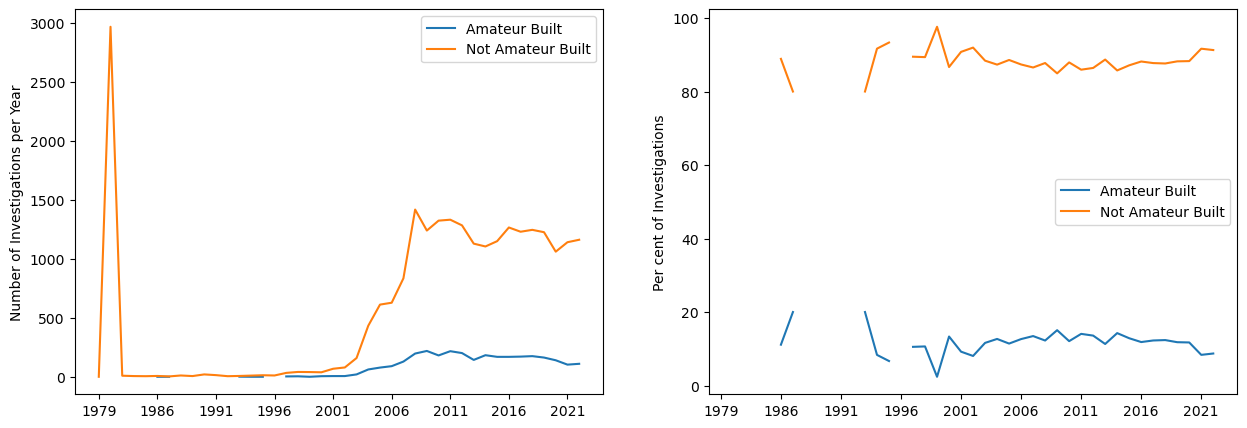

In [272]:
# Compare amateur and professional over time. Two series, one for num of amateur built per year,and other for non amateur built.
#Merge into a single dataframe.

df_amblt_year = df.loc[df['Amateur_Built'] == 'Yes']['Year'].value_counts().sort_index().reset_index()
df_amblt_year.columns = df_amblt_year.columns.str.replace('count', 'Amateur_Built')

df_not_amblt_year = df.loc[df['Amateur_Built'] == 'No']['Year'].value_counts().sort_index().reset_index()
df_not_amblt_year.columns = df_not_amblt_year.columns.str.replace('count', 'Not_Amateur_Built')

df_amblt_merge = df_amblt_year.merge(df_not_amblt_year, how = 'outer')

# Calculate per cent of investigations were related to amateur-built and professional planes

df_amblt_merge ['Amateur_Built_pct'] = df_amblt_merge['Amateur_Built'] / (df_amblt_merge['Amateur_Built'] + df_amblt_merge['Not_Amateur_Built']) * 100
df_amblt_merge ['Not_Amateur_Built_pct'] = df_amblt_merge['Not_Amateur_Built'] / (df_amblt_merge['Amateur_Built'] + df_amblt_merge['Not_Amateur_Built']) * 100

# Create plot with counts of investigations and per cent

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize =(15,5))
max_xticks = 5

ax1.plot(df_amblt_merge['Year'], df_amblt_merge['Amateur_Built'], label='Amateur Built')
ax1.plot(df_amblt_merge['Year'], df_amblt_merge['Not_Amateur_Built'], label='Not Amateur Built')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(max_xticks))
legend = ax1.legend()

ax2.plot(df_amblt_merge['Year'], df_amblt_merge['Amateur_Built_pct'], label='Amateur Built')
ax2.plot(df_amblt_merge['Year'], df_amblt_merge['Not_Amateur_Built_pct'], label='Not Amateur Built')
ax2.xaxis.set_major_locator(ticker.MultipleLocator(max_xticks))
legend = ax2.legend()

ax1.set_ylabel('Number of Investigations per Year');
ax2.set_ylabel('Per cent of Investigations');

In [286]:
# Same Makes showing up as different because of capitalization. Changing all Makes and Model to Title case

df.Make = df.Make.str.title()
df.Model = df.Model.str.title()

In [327]:
# Since the ultimate goal is to make recommendations about Make and Model, all events without
# information about Make or Model will be filtered out.

df = df.dropna(subset=['Make', 'Model'])

In [329]:
print(df.info(), '\n \n')
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 27580 entries, 5 to 90345
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event_Id                27580 non-null  object 
 1   Investigation_Type      27580 non-null  object 
 2   Accident_Number         27580 non-null  object 
 3   Event_Date              27580 non-null  object 
 4   Location                27573 non-null  object 
 5   Country                 27573 non-null  object 
 6   Latitude                22082 non-null  object 
 7   Longitude               22073 non-null  object 
 8   Airport_Code            17658 non-null  object 
 9   Airport_Name            18200 non-null  object 
 10  Injury_Severity         26768 non-null  object 
 11  Aircraft_damage         26301 non-null  object 
 12  Aircraft_Category       27580 non-null  object 
 13  Registration_Number     27348 non-null  object 
 14  Make                    27580 non-null  obj

,Event_Id,Investigation_Type,Accident_Number,Event_Date,Location,Country,Latitude,Longitude,Airport_Code,Airport_Name,...,Air_carrier,Total_Fatal_Injuries,Total_Serious_Injuries,Total_Minor_Injuries,Total_Uninjured,Weather_Condition,Broad_phase_of_flight,Report_Status,Publication_Date,Year
5,20170710X52551,Accident,NYC79AA106,1979-09-17,"BOSTON, MA",United States,42.445277,-70.758333,NaN,NaN,...,Air Canada,NaN,NaN,1.0,44.0,VMC,Climb,Probable Cause,19-09-2017,1979
7,20020909X01562,Accident,SEA82DA022,1982-01-01,"PULLMAN, WA",United States,NaN,NaN,NaN,BLACKBURN AG STRIP,...,NaN,0.0,0.0,0.0,2.0,VMC,Takeoff,Probable Cause,01-01-1982,1982
8,20020909X01561,Accident,NYC82DA015,1982-01-01,"EAST HANOVER, NJ",United States,NaN,NaN,N58,HANOVER,...,NaN,0.0,0.0,0.0,2.0,IMC,Landing,Probable Cause,01-01-1982,1982
12,20020917X02148,Accident,FTW82FRJ07,1982-01-02,"HOMER, LA",United States,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,1.0,0.0,IMC,Cruise,Probable Cause,02-01-1983,1982
13,20020917X02134,Accident,FTW82FRA14,1982-01-02,"HEARNE, TX",United States,NaN,NaN,T72,HEARNE MUNICIPAL,...,NaN,1.0,0.0,0.0,0.0,IMC,Takeoff,Probable Cause,02-01-1983,1982


In [331]:
# Assess Make of planes for amateur built

df.loc[df['Amateur_Built'] == 'Yes']['Make'].value_counts()

Make
Vans                   110
Zenith                  38
Rans                    31
Cessna                  30
Lancair                 24
                      ... 
Swezey T/Molnar D        1
Carlesimo                1
Moynahan                 1
Jorritsma Jerrold S      1
Greg Hobbs               1
Name: count, Length: 2506, dtype: int64

In [333]:
# Assess Make of planes for professionally built

df.loc[df['Amateur_Built'] == 'No']['Make'].value_counts()

Make
Cessna                  8439
Piper                   4699
Beech                   1684
Boeing                  1306
Mooney                   417
                        ... 
M7Aero                     1
Aviocar Casa               1
Loehle Aircraft Corp       1
Interplane S R O           1
Orlican S R O              1
Name: count, Length: 1127, dtype: int64

In [337]:
# The company will utilize professionally built planes. To best understand risk assodciated wiht professionally
# built planes, amateur-built will be removed from the dataset.

df = df.loc[df['Amateur_Built'] == 'No']

In [339]:
print(df.info(), '\n \n')
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 24398 entries, 5 to 90345
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event_Id                24398 non-null  object 
 1   Investigation_Type      24398 non-null  object 
 2   Accident_Number         24398 non-null  object 
 3   Event_Date              24398 non-null  object 
 4   Location                24392 non-null  object 
 5   Country                 24391 non-null  object 
 6   Latitude                19162 non-null  object 
 7   Longitude               19156 non-null  object 
 8   Airport_Code            15477 non-null  object 
 9   Airport_Name            15973 non-null  object 
 10  Injury_Severity         23587 non-null  object 
 11  Aircraft_damage         23131 non-null  object 
 12  Aircraft_Category       24398 non-null  object 
 13  Registration_Number     24195 non-null  object 
 14  Make                    24398 non-null  obj

,Event_Id,Investigation_Type,Accident_Number,Event_Date,Location,Country,Latitude,Longitude,Airport_Code,Airport_Name,...,Air_carrier,Total_Fatal_Injuries,Total_Serious_Injuries,Total_Minor_Injuries,Total_Uninjured,Weather_Condition,Broad_phase_of_flight,Report_Status,Publication_Date,Year
5,20170710X52551,Accident,NYC79AA106,1979-09-17,"BOSTON, MA",United States,42.445277,-70.758333,NaN,NaN,...,Air Canada,NaN,NaN,1.0,44.0,VMC,Climb,Probable Cause,19-09-2017,1979
7,20020909X01562,Accident,SEA82DA022,1982-01-01,"PULLMAN, WA",United States,NaN,NaN,NaN,BLACKBURN AG STRIP,...,NaN,0.0,0.0,0.0,2.0,VMC,Takeoff,Probable Cause,01-01-1982,1982
8,20020909X01561,Accident,NYC82DA015,1982-01-01,"EAST HANOVER, NJ",United States,NaN,NaN,N58,HANOVER,...,NaN,0.0,0.0,0.0,2.0,IMC,Landing,Probable Cause,01-01-1982,1982
12,20020917X02148,Accident,FTW82FRJ07,1982-01-02,"HOMER, LA",United States,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,1.0,0.0,IMC,Cruise,Probable Cause,02-01-1983,1982
13,20020917X02134,Accident,FTW82FRA14,1982-01-02,"HEARNE, TX",United States,NaN,NaN,T72,HEARNE MUNICIPAL,...,NaN,1.0,0.0,0.0,0.0,IMC,Takeoff,Probable Cause,02-01-1983,1982


### Dataframe column assessment changes

In [192]:
for i in range(len(df.columns)):
    print(df.iloc[:,i].value_counts(), '\n')

Event.Id
20001212X19172    3
20001214X45071    3
20220730105623    2
20051213X01965    2
20001212X16765    2
                 ..
20001211X14216    1
20001211X14239    1
20001211X14207    1
20001211X14204    1
20221230106513    1
Name: count, Length: 87951, dtype: int64 

Investigation.Type
Accident      85015
Incident       3874
25-09-2020      702
26-09-2020       60
02-02-2021       39
              ...  
13-09-2021        1
04-08-2021        1
05-08-2022        1
03-11-2020        1
06-01-2021        1
Name: count, Length: 71, dtype: int64 

Accident.Number
CEN22LA149    2
WPR23LA041    2
WPR23LA045    2
DCA22WA214    2
DCA22WA089    2
             ..
LAX92FA065    1
ANC92T#A12    1
MIA92LA049    1
NYC92LA048    1
ERA23LA097    1
Name: count, Length: 88863, dtype: int64 

Event.Date
1984-06-30    25
1982-05-16    25
2000-07-08    25
1983-08-05    24
1984-08-25    24
              ..
2014-03-16     1
2014-03-15     1
2014-03-12     1
2014-03-10     1
2022-12-29     1
Name: count, Len

In [142]:
df['Year'] = [str(year).split('-')[0] for year in df['Event.Date']]
df

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date,Year
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,...,NaN,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaN,1948
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,...,NaN,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996,1962
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.922223,-81.878056,NaN,NaN,...,NaN,3.0,NaN,NaN,NaN,IMC,Cruise,Probable Cause,26-02-2007,1974
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,NaN,NaN,NaN,NaN,...,NaN,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,12-09-2000,1977
4,20041105X01764,Accident,CHI79FA064,1979-08-02,"Canton, OH",United States,NaN,NaN,NaN,NaN,...,NaN,1.0,2.0,NaN,0.0,VMC,Approach,Probable Cause,16-04-1980,1979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90343,20221227106491,Accident,ERA23LA093,2022-12-26,"Annapolis, MD",United States,NaN,NaN,NaN,NaN,...,NaN,0.0,1.0,0.0,0.0,NaN,NaN,NaN,29-12-2022,2022
90344,20221227106494,Accident,ERA23LA095,2022-12-26,"Hampton, NH",United States,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,2022
90345,20221227106497,Accident,WPR23LA075,2022-12-26,"Payson, AZ",United States,341525N,1112021W,PAN,PAYSON,...,NaN,0.0,0.0,0.0,1.0,VMC,NaN,NaN,27-12-2022,2022
90346,20221227106498,Accident,WPR23LA076,2022-12-26,"Morgan, UT",United States,NaN,NaN,NaN,NaN,...,MC CESSNA 210N LLC,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,2022


In [144]:
df = df.loc[df['Aircraft.Category'] == 'Airplane']
df

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date,Year
5,20170710X52551,Accident,NYC79AA106,1979-09-17,"BOSTON, MA",United States,42.445277,-70.758333,NaN,NaN,...,Air Canada,NaN,NaN,1.0,44.0,VMC,Climb,Probable Cause,19-09-2017,1979
7,20020909X01562,Accident,SEA82DA022,1982-01-01,"PULLMAN, WA",United States,NaN,NaN,NaN,BLACKBURN AG STRIP,...,NaN,0.0,0.0,0.0,2.0,VMC,Takeoff,Probable Cause,01-01-1982,1982
8,20020909X01561,Accident,NYC82DA015,1982-01-01,"EAST HANOVER, NJ",United States,NaN,NaN,N58,HANOVER,...,NaN,0.0,0.0,0.0,2.0,IMC,Landing,Probable Cause,01-01-1982,1982
12,20020917X02148,Accident,FTW82FRJ07,1982-01-02,"HOMER, LA",United States,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,1.0,0.0,IMC,Cruise,Probable Cause,02-01-1983,1982
13,20020917X02134,Accident,FTW82FRA14,1982-01-02,"HEARNE, TX",United States,NaN,NaN,T72,HEARNE MUNICIPAL,...,NaN,1.0,0.0,0.0,0.0,IMC,Takeoff,Probable Cause,02-01-1983,1982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90328,20221213106455,Accident,WPR23LA065,2022-12-13,"Lewistown, MT",United States,047257N,0109280W,KLWT,Lewiston Municipal Airport,...,NaN,0.0,0.0,0.0,1.0,NaN,NaN,NaN,14-12-2022,2022
90332,20221215106463,Accident,ERA23LA090,2022-12-14,"San Juan, PR",United States,182724N,0066554W,SIG,FERNANDO LUIS RIBAS DOMINICCI,...,SKY WEST AVIATION INC TRUSTEE,0.0,0.0,0.0,1.0,VMC,NaN,NaN,27-12-2022,2022
90335,20221219106475,Accident,WPR23LA069,2022-12-15,"Wichita, KS",United States,373829N,0972635W,ICT,WICHITA DWIGHT D EISENHOWER NT,...,NaN,0.0,0.0,0.0,1.0,NaN,NaN,NaN,19-12-2022,2022
90336,20221219106470,Accident,ERA23LA091,2022-12-16,"Brooksville, FL",United States,282825N,0822719W,BKV,BROOKSVILLE-TAMPA BAY RGNL,...,GERBER RICHARD E,0.0,1.0,0.0,0.0,VMC,NaN,NaN,23-12-2022,2022


#### Event IDs

In [108]:
#Event IDs
event_id_series = df['Event.Id'].value_counts()
event_id_series

Event.Id
20070426X00458    2
20001207X03162    2
20001208X07896    2
20220921105978    2
20010304X00536    2
                 ..
20090808X55842    1
20090811X33954    1
20090811X02920    1
20090810X50332    1
20221227106497    1
Name: count, Length: 27524, dtype: int64

In [110]:
#code to assess duplicate Event IDs
event_id_series.loc[event_id_series.values > 1]

Event.Id
20070426X00458    2
20001207X03162    2
20001208X07896    2
20220921105978    2
20010304X00536    2
                 ..
20070705X00879    2
20020917X04994    2
20020917X03642    2
20070618X00759    2
20020917X04883    2
Name: count, Length: 93, dtype: int64

In [114]:
df['Aircraft.damage'].value_counts()

Aircraft.damage
Substantial    21719
Destroyed       3552
Minor            964
Unknown          100
Name: count, dtype: int64

In [116]:
df['FAR.Description'].value_counts()

FAR.Description
091                               15901
Part 91: General Aviation          5688
NUSN                               1157
NUSC                                807
137                                 744
121                                 653
135                                 540
Part 137: Agricultural              360
Part 135: Air Taxi & Commuter       235
UNK                                 232
129                                 202
Part 121: Air Carrier               165
PUBU                                126
Part 129: Foreign                    89
Non-U.S., Non-Commercial             78
Non-U.S., Commercial                 74
Unknown                              19
091K                                 14
Public Use                           13
125                                   5
Part 125: 20+ Pax,6000+ lbs           5
ARMF                                  4
Part 133: Rotorcraft Ext. Load        2
Part 91 Subpart K: Fractional         1
Armed Forces            

In [118]:
#Distribution of Investigations Types
df['Investigation.Type'].value_counts()

Investigation.Type
Accident    25963
Incident     1654
Name: count, dtype: int64

*** 'Investigation.Type' appears to have three types of investigations: Accident, Incident and dates. Considering filtering out the dates.

*** Consider removing all entries where 'Investigation.Type' = to a date. Did a high-level review of this subset and all were missing rest of data.

In [120]:
df['Location'].value_counts()

Location
Anchorage, AK        99
Phoenix, AZ          72
Talkeetna, AK        69
Atlanta, GA          68
Palmer, AK           67
                     ..
Mt. Comfort, IN       1
Rome, NY              1
BERGHEIM, TX          1
Diamond Point, WA     1
Woodsfield, OH        1
Name: count, Length: 13029, dtype: int64

In [122]:
df['Air.carrier'].value_counts()

Air.carrier
Pilot                    231
American Airlines         47
United Airlines           43
Delta Air Lines           42
SOUTHWEST AIRLINES CO     41
                        ... 
GREEN RUSSELL E SR         1
WOODSUM RICHARD P          1
William G. Faulkner        1
Roy D. Harris              1
GERBER RICHARD E           1
Name: count, Length: 9592, dtype: int64

In [295]:
df['Purpose_of_flight'].value_counts()

Purpose_of_flight
Personal                     16154
Instructional                 3212
Aerial Application            1068
Unknown                        886
Business                       785
Positioning                    359
Flight Test                    226
Ferry                          176
Aerial Observation             170
Skydiving                      166
Other Work Use                 158
Executive/corporate            151
Banner Tow                      89
Air Race show                   74
Public Aircraft - Federal       53
Public Aircraft                 43
Glider Tow                      35
Public Aircraft - State         24
Firefighting                    17
Public Aircraft - Local         12
Air Race/show                    7
ASHO                             6
Air Drop                         3
PUBS                             3
External Load                    1
Name: count, dtype: int64

In [313]:
df_group = df.groupby(['Purpose_of_flight', 'Amateur_Built'])

df_group.groups.keys()

dict_keys([('ASHO', 'No'), ('ASHO', 'Yes'), ('Aerial Application', 'No'), ('Aerial Application', 'Yes'), ('Aerial Observation', 'No'), ('Air Drop', 'No'), ('Air Race show', 'No'), ('Air Race show', 'Yes'), ('Air Race/show', 'No'), ('Air Race/show', 'Yes'), ('Banner Tow', 'No'), ('Business', 'No'), ('Business', 'Yes'), ('Business', nan), ('Executive/corporate', 'No'), ('Executive/corporate', 'Yes'), ('External Load', 'No'), ('Ferry', 'No'), ('Ferry', 'Yes'), ('Firefighting', 'No'), ('Flight Test', 'No'), ('Flight Test', 'Yes'), ('Glider Tow', 'No'), ('Instructional', 'No'), ('Instructional', 'Yes'), ('Other Work Use', 'No'), ('Other Work Use', 'Yes'), ('PUBS', 'No'), ('Personal', 'No'), ('Personal', 'Yes'), ('Personal', nan), ('Positioning', 'No'), ('Positioning', 'Yes'), ('Public Aircraft', 'No'), ('Public Aircraft', 'Yes'), ('Public Aircraft - Federal', 'No'), ('Public Aircraft - Federal', 'Yes'), ('Public Aircraft - Local', 'No'), ('Public Aircraft - State', 'No'), ('Skydiving', 'No'

In [325]:
df.groupby(by=['Make', 'Amateur_Built'])


In [126]:
df['Aircraft.Category'].value_counts()

Aircraft.Category
Airplane    27617
Name: count, dtype: int64

In [ ]:
df

In [210]:
inv_years = df['Year']
inv_years_dist = inv_years.value_counts().sort_index()
inv_years_dist

Year
1979       1
1982    3175
1983      10
1984       7
1985       6
1986       9
1987       5
1988      12
1989       7
1990      21
1991      17
1992       6
1993      10
1994      12
1995      15
1996      12
1997      38
1998      47
1999      43
2000      46
2001      81
2002      88
2003     181
2004     499
2005     696
2006     722
2007     966
2008    1617
2009    1461
2010    1507
2011    1551
2012    1487
2013    1274
2014    1290
2015    1321
2016    1437
2017    1403
2018    1423
2019    1391
2020    1203
2021    1246
2022    1274
Name: count, dtype: int64

Text(0, 0.5, 'Number of Investigations per Year')

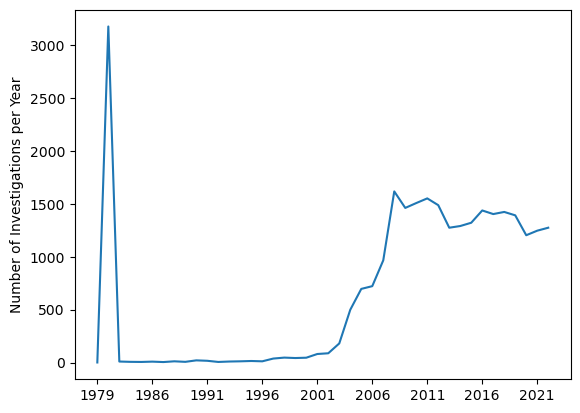

In [212]:
fig, ax = plt.subplots()

ax.plot(inv_years_dist.index, inv_years_dist.values)
max_xticks = 5
ax.xaxis.set_major_locator(ticker.MultipleLocator(max_xticks))

plt.ylabel('Number of Investigations per Year')


In [134]:
df.loc[df['Year'] == '1982']

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date,Year
7,20020909X01562,Accident,SEA82DA022,1982-01-01,"PULLMAN, WA",United States,NaN,NaN,NaN,BLACKBURN AG STRIP,...,NaN,0.0,0.0,0.0,2.0,VMC,Takeoff,Probable Cause,01-01-1982,1982
8,20020909X01561,Accident,NYC82DA015,1982-01-01,"EAST HANOVER, NJ",United States,NaN,NaN,N58,HANOVER,...,NaN,0.0,0.0,0.0,2.0,IMC,Landing,Probable Cause,01-01-1982,1982
12,20020917X02148,Accident,FTW82FRJ07,1982-01-02,"HOMER, LA",United States,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,1.0,0.0,IMC,Cruise,Probable Cause,02-01-1983,1982
13,20020917X02134,Accident,FTW82FRA14,1982-01-02,"HEARNE, TX",United States,NaN,NaN,T72,HEARNE MUNICIPAL,...,NaN,1.0,0.0,0.0,0.0,IMC,Takeoff,Probable Cause,02-01-1983,1982
14,20020917X02119,Accident,FTW82FPJ10,1982-01-02,"CHICKASHA, OK",United States,NaN,NaN,NaN,NaN,...,NaN,1.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,02-01-1983,1982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3594,20020917X04872,Accident,LAX83LA062,1982-12-31,"PRESCOTT, AZ",United States,NaN,NaN,PRC,ERNEST A. LOVE,...,NaN,0.0,0.0,0.0,2.0,VMC,Landing,Probable Cause,31-12-1983,1982
3595,20020917X04250,Accident,ANC83LAG01,1982-12-31,"CHUGIAK, AK",United States,NaN,NaN,Z15,BIRCHWOOD AIRPORT,...,NaN,0.0,0.0,0.0,1.0,VMC,Takeoff,Probable Cause,31-12-1983,1982
3596,20020917X04874,Accident,LAX83LA065,1982-12-31,"CALISTOGA, CA",United States,NaN,NaN,058,CALISTOGA,...,NaN,0.0,0.0,0.0,1.0,UNK,Landing,Probable Cause,31-12-1983,1982
3597,20020917X04728,Accident,FTW83LA074,1982-12-31,"HOUSTON, TX",United States,NaN,NaN,T17,WEISER,...,Air Exchange,0.0,0.0,0.0,1.0,VMC,Cruise,Probable Cause,31-12-1983,1982


In [136]:
df['Country'].value_counts()

Country
United States               24229
Brazil                        244
United Kingdom                214
Mexico                        207
Canada                        176
                            ...  
Reunion                         1
Singapore                       1
Cyprus                          1
Madagascar                      1
Turks and Caicos Islands        1
Name: count, Length: 168, dtype: int64

In [138]:
df['Amateur.Built'].value_counts()

Amateur.Built
No     24417
Yes     3183
Name: count, dtype: int64